In [ ]:
import keras
from keras.models import Model
from keras.layers import *
from keras.utils import *
from tensorflow.keras.optimizers import *
from keras import backend as K
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
image_path='/content/gdrive/MyDrive/dataset/output.png'
image_path2 = '/content/gdrive/MyDrive/dataset/output2.png'
image_path3='/content/gdrive/MyDrive/dataset/output3.png'

# Display the image
img = mpimg.imread(image_path)
img2=mpimg.imread(image_path2)
img3=mpimg.imread(image_path3)





smooth = 0.0000001

def dcp_block(x, num_filters):
    conv1 = Conv2D(num_filters, (1, 1), padding='same', activation='relu')(x)
    conv2 = Conv2D(num_filters, (3, 3), padding='same', activation='relu')(x)
    conv3 = Conv2D(num_filters, (5, 5), padding='same', activation='relu')(x)
    concat = concatenate([conv1, conv2, conv3], axis=-1)
    return concat

def aspp(x,out_shape):
  b0=SeparableConv2D(256,(1,1),padding="same",use_bias=False)(x)
  b0=BatchNormalization()(b0)
  b0=Activation("relu")(b0)
  b1=DepthwiseConv2D((3,3),dilation_rate=(1,1),padding="same",use_bias=False)(x)
  b1=BatchNormalization()(b1)
  b1=Activation("relu")(b1)
  b1=SeparableConv2D(256,(1,1),padding="same",use_bias=False)(b1)
  b1=BatchNormalization()(b1)
  b1=Activation("relu")(b1)

  b2=DepthwiseConv2D((3,3),dilation_rate=(3,3),padding="same",use_bias=False)(x)
  b2=BatchNormalization()(b2)
  b2=Activation("relu")(b2)
  b2=SeparableConv2D(256,(1,1),padding="same",use_bias=False)(b2)
  b2=BatchNormalization()(b2)
  b2=Activation("relu")(b2)

  b3=DepthwiseConv2D((3,3),dilation_rate=(6,6),padding="same",use_bias=False)(x)
  b3=BatchNormalization()(b3)
  b3=Activation("relu")(b3)
  b3=SeparableConv2D(256,(1,1),padding="same",use_bias=False)(b3)
  b3=BatchNormalization()(b3)
  b3=Activation("relu")(b3)

  b4=AveragePooling2D(pool_size=(out_shape,out_shape))(x)
  b4=SeparableConv2D(256,(1,1),padding="same",use_bias=False)(b4)
  b4=BatchNormalization()(b4)
  b4=Activation("relu")(b4)
  dcp_output = dcp_block(x, 256)
  #concat_output = concatenate([b0, b1, b2, b3, b4, dcp_output], axis=-1)

  return x

def inception_module(x, filters):
    conv1 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)

    conv3 = Conv2D(filters, (3, 3), padding='same', activation='relu')(x)

    conv5 = Conv2D(filters, (5, 5), padding='same', activation='relu')(x)

    maxpool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
    conv_mp = Conv2D(filters, (1, 1), padding='same', activation='relu')(maxpool)

    inception_output = concatenate([conv1, conv3, conv5, conv_mp], axis=-1)
    return inception_output


def jacc_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - ((intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth))

def bn_relu(input_tensor):
    input_tensor = BatchNormalization(axis=3)(input_tensor)
    return Activation("relu")(input_tensor)

def contr_arm(input_tensor, filters, kernel_size ):
    x = SeparableConv2D(filters, kernel_size, padding='same')(input_tensor)
    x = bn_relu(x)

    x0 = SeparableConv2D(filters, kernel_size, padding='same')(x)
    x0 = bn_relu(x0)

    x = SeparableConv2D(filters, kernel_size, padding='same')(x0)
    x = bn_relu(x)

    filters_b = filters // 2
    kernel_size_b = (kernel_size[0]-2, kernel_size[0]-2)  # creates a kernl size of (1,1) out of (3,3)

    x1 = SeparableConv2D(filters_b, kernel_size_b, padding='same')(input_tensor)
    x1 = bn_relu(x1)

    x1 = concatenate([input_tensor, x1], axis=3)
    x2 = SeparableConv2D(filters, kernel_size_b, padding='same')(x0)
    x2 = bn_relu(x2)

    x = keras.layers.add([x, x1, x2])
    x = Activation("relu")(x)
    return x


def bridge(input_tensor, filters, kernel_size):
    x = SeparableConv2D(filters, kernel_size, padding='same')(input_tensor)
    x = bn_relu(x)
    x = SeparableConv2D(filters, kernel_size, padding='same')(x)
    x = Dropout(.15)(x)
    x = bn_relu(x)

    filters_b = filters // 2
    kernel_size_b = (kernel_size[0]-2, kernel_size[0]-2)  # creates a kernl size of (1,1) out of (3,3)

    x1 =SeparableConv2D(filters_b, kernel_size_b, padding='same')(input_tensor)
    x1 = bn_relu(x1)

    x1 = concatenate([input_tensor, x1], axis=3)
    x = keras.layers.add([x, x1])
    x = Activation("relu")(x)
    return x


def conv_block_exp_path(input_tensor, filters, kernel_size):
    x = Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = bn_relu(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = bn_relu(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = bn_relu(x)
    return x


def add_block_exp_path(input_tensor1, input_tensor2, input_tensor3):
    x = keras.layers.add([input_tensor1, input_tensor2, input_tensor3])
    x = Activation("relu")(x)
    return x

def improve_ff_block(input_tensor1, pure_ff):
    for ix in range(1):
        if ix == 0:
            x1 = input_tensor1
        x1 = concatenate([x1, input_tensor1], axis=3)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)

    x = keras.layers.add([x1, pure_ff])
    x = Activation("relu")(x)
    return x


def model_arch(input_rows=256, input_cols=256, num_of_channels=3, num_of_classes=1):
    inputs = Input((input_rows, input_cols, num_of_channels))
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)

    conv1 = contr_arm(conv1, 32, (3, 3))
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = contr_arm(pool1, 64, (3, 3))
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = contr_arm(pool2, 128, (3, 3))
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = contr_arm(pool3, 256, (3, 3))
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = contr_arm(pool4, 512, (3, 3))
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    conv6 = bridge(pool5, 1024, (3, 3))
    conv6 = inception_module(conv6, 512)
    conv6  = aspp(conv6,input_rows/32)

    convT7 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv6)
    prevup7 = improve_ff_block(input_tensor1=conv4, pure_ff=conv5)
    up7 = concatenate([convT7, prevup7], axis=3)
    conv7 = conv_block_exp_path(input_tensor=up7, filters=512, kernel_size=(3, 3))
    conv7 = add_block_exp_path(conv7, conv5, convT7)

    convT8 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv7)
    prevup8 = improve_ff_block(input_tensor1=conv3, pure_ff=conv4)
    up8 = concatenate([convT8, prevup8], axis=3)
    conv8 = conv_block_exp_path(input_tensor=up8, filters=256, kernel_size=(3, 3))
    conv8 = add_block_exp_path(input_tensor1=conv8, input_tensor2=conv4, input_tensor3=convT8)

    convT9 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv8)
    prevup9 = improve_ff_block(input_tensor1=conv2,pure_ff=conv3)
    up9 = concatenate([convT9, prevup9], axis=3)
    conv9 = conv_block_exp_path(input_tensor=up9, filters=128, kernel_size=(3, 3))
    conv9 = add_block_exp_path(input_tensor1=conv9, input_tensor2=conv3, input_tensor3=convT9)

    convT10 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv9)
    prevup10 = improve_ff_block(input_tensor1=conv1, pure_ff=conv2)
    up10 = concatenate([convT10, prevup10], axis=3)
    conv10 = conv_block_exp_path(input_tensor=up10, filters=64, kernel_size=(3, 3))
    conv10 = add_block_exp_path(input_tensor1=conv10, input_tensor2=conv2, input_tensor3=convT10)

    convT11 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv10)
    up11 = concatenate([convT11, conv1], axis=3)
    conv11 = conv_block_exp_path(input_tensor=up11, filters=32, kernel_size=(3, 3))
    conv11 = add_block_exp_path(input_tensor1=conv11, input_tensor2=conv1, input_tensor3=convT11)

    conv12 = Conv2D(num_of_classes, (1, 1), activation='sigmoid')(conv11)

    return Model(inputs=[inputs], outputs=[conv12])



model = model_arch(input_rows=256, input_cols=256 ,num_of_channels=3, num_of_classes=1)
# model.compile(optimizer = Adam(learning_rate = 1e-4), loss = jacc_coef, metrics = [jacc_coef,'accuracy'])

file_path='best_model_weights.h5'
checkpoint = ModelCheckpoint(filepath=file_path, monitor='accuracy', save_best_only=True, save_weights_only=True, mode='max')

# Compile your model
model.compile(optimizer=Adam(learning_rate=1e-4), loss=jacc_coef, metrics=['accuracy'])
# model = keras.models.load_model(file_path)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:

from IPython import display

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
import random
from keras.callbacks import TensorBoard
#from keras import backend as K
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from PIL import Image
import sys

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

TRAIN_PATH_R = '/content/gdrive/MyDrive/dataset/B4/train/'
TRAIN_PATH_G = '/content/gdrive/MyDrive/dataset/B3/train/'
TRAIN_PATH_B = '/content/gdrive/MyDrive/dataset/B2/train/'

TEST_PATH_R = '/content/gdrive/MyDrive/dataset/B4/test/'
TEST_PATH_G = '/content/gdrive/MyDrive/dataset/B3/test/'
TEST_PATH_B = '/content/gdrive/MyDrive/dataset/B2/test/'

In [ ]:
X_train = np.zeros((350, IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((350, IMG_WIDTH, IMG_WIDTH, 1), dtype=np.float32)
img = np.zeros((IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)

tr=np.zeros(350)
te=np.zeros(10)

for i in range(350):
       tr[i]=i;
for i in range(10):
       te[i]=i;


for n, id_ in tqdm(enumerate(tr),total=350):
       red    = Image.open(TRAIN_PATH_R + str(int(id_)) + '.png').convert('L')
       green  = Image.open(TRAIN_PATH_G + str(int(id_)) + '.png').convert('L')
       blue   = Image.open(TRAIN_PATH_B + str(int(id_)) + '.png').convert('L')

       rgb = Image.merge("RGB",(red,green,blue))
       img_b = np.asarray(rgb)
       img_b = resize(img_b, (IMG_HEIGHT, IMG_WIDTH, 3), mode='constant', preserve_range=True)
       img_b=img_b/255.0
       X_train[n] = img_b
       mask = imread('/content/gdrive/MyDrive/dataset/BQA/train/' + str(int(id_)) + '.png')[:,:,:IMG_CHANNELS]
       mask1 = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
       Y_train[n] =mask1/255.0
       for io in range(256):
          for jo in range(256):
           if (Y_train[n][io][jo]>0.3):
             Y_train[n][io][jo]=1
           else:
             Y_train[n][io][jo]=0

X_test = np.zeros((10, IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_test = np.zeros((10, IMG_WIDTH, IMG_WIDTH, 1), dtype=np.float32)
img = np.zeros((IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
sizes_test = []

for n, id_ in tqdm(enumerate(te),total=10):
       red    = Image.open(TEST_PATH_R + str(170+int(id_)) + '.png').convert('L')
       green  = Image.open(TEST_PATH_G + str(170+int(id_)) + '.png').convert('L')
       blue   = Image.open(TEST_PATH_B + str(170+int(id_)) + '.png').convert('L')
       rgb = Image.merge("RGB",(red,green,blue))
       img_b = np.asarray(rgb)
       img_b = resize(img_b, (IMG_HEIGHT, IMG_WIDTH, 3), mode='constant', preserve_range=True)
       img_b=img_b/255.0
       X_test[n] = img_b

       mask = imread('/content/gdrive/MyDrive/dataset/BQA/test/' + str(int(170+id_)) + '.png')[:,:,:IMG_CHANNELS]
       mask1 = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
       Y_test[n] =mask1/255.0
       for io in range(256):
         for jo in range(256):
           if (Y_test[n][io][jo]>0.3):
             Y_test[n][io][jo]=1
           else:
             Y_test[n][io][jo]=0


results = model.fit(X_train, Y_train, validation_split=0.5, batch_size=16, epochs=50, verbose=1, callbacks=[checkpoint])


100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


Epoch 1/50
11/11 [==============================] - 25s 1s/step - loss: 0.1332 - accuracy: 0.9753 - val_loss: 0.9991 - val_accuracy: 0.8502
Epoch 2/50
11/11 [==============================] - 13s 1s/step - loss: 0.1284 - accuracy: 0.9752 - val_loss: 0.9992 - val_accuracy: 0.8502
Epoch 3/50
11/11 [==============================] - 12s 1s/step - loss: 0.1263 - accuracy: 0.9761 - val_loss: 0.9998 - val_accuracy: 0.8502
Epoch 4/50
11/11 [==============================] - 13s 1s/step - loss: 0.1244 - accuracy: 0.9766 - val_loss: 0.9991 - val_accuracy: 0.8502
Epoch 5/50
11/11 [==============================] - 13s 1s/step - loss: 0.1289 - accuracy: 0.9746 - val_loss: 0.9998 - val_accuracy: 0.8502
Epoch 6/50
11/11 [==============================] - 12s 1s/step - loss: 0.1284 - accuracy: 0.9754 - val_loss: 0.9997 - val_accuracy: 0.8502
Epoch 7/50
11/11 [==============================] - 13s 1s/step - loss: 0.1309 - accuracy: 0.9766 - val_loss: 0.9991 - val_accuracy: 0.8502
Epoch 8/50
11/11 [==

In [ ]:
file_path = 'best_model_weights.h5'
model.load_weights(file_path)
results = model.evaluate(X_test, Y_test)
results1=model.evaluate(X_train,Y_train)

# Extract the accuracy value from the results
train_accuracy = results1[1]
# test_jacc_coef = results[1]  # This may be jacc_coef or another metric
test_accuracy = results[1]

# Print the accuracy with formatting
print(f'Test Accuracy: {test_accuracy:.4f}')

11/11 [==============================] - 4s 384ms/step - loss: 0.1933 - accuracy: 0.9723
Test Accuracy: 0.9723


In [ ]:


preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.95):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.float32)
preds_val_t = (preds_val > 0.5).astype(np.float32)
preds_test_t = (preds_test > 0.5).astype(np.float32)

train_acc = model.evaluate(X_train, Y_train, verbose=1)
test_acc = model.evaluate(X_test, Y_test, verbose=1)

In [ ]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.95):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.float32)
preds_val_t = (preds_val > 0.5).astype(np.float32)
preds_test_t = (preds_test > 0.5).astype(np.float32)


1/1 [==============================] - 0s 29ms/step


In [ ]:
from sklearn.metrics import confusion_matrix

def precision(gt,mask):
 gt = gt.flatten()
 mask = mask.flatten()
 tn,fp,fn,tp = confusion_matrix(gt,mask).ravel()
 prec = tp/(tp+fp)
 return(prec)

####recall---
def recall(gt,mask):
 gt = gt.flatten()
 mask = mask.flatten()
 tn,fp,fn,tp = confusion_matrix(gt,mask).ravel()
 rec = tp/(tp+fn)
 return(rec)

###f1 score--

def f1_score(prec,rec):
 f1 = 2*(prec*rec)/(prec+rec)
 return f1



def Overall(gt,mask):
    gt = gt.flatten()
    mask = mask.flatten()
    tn,fp,fn,tp = confusion_matrix(gt,mask).ravel()
    rec = (tp+tn)/(tp+fp+fn+tn)
    return(rec)

sum = 0
for i in range(len(Y_test)):
 sum = sum + precision(Y_test[i],preds_test_t[i])
prec = sum/len(Y_test)

sum = 0
for i in range(len(Y_test)):
 sum = sum + recall(Y_test[i],preds_test_t[i])
rec = sum/len(Y_test)

# sum = 0
# for i in range(len(Y_test)):
#  sum = sum + jaccard(Y_test[i],preds_test_t[i])
# jaccard1 = sum/len(Y_test)

sum = 0
for i in range(len(Y_test)):
 sum = sum + Overall(Y_test[i],preds_test_t[i])
Overall1 = sum/len(Y_test)

f1 = f1_score(prec,rec)

print("final f1", f1)
print("final precision",prec)
print("final recall",rec)

final f1 0.7480528471433169
final precision 0.8230226488178992
final recall 0.6856009038539443


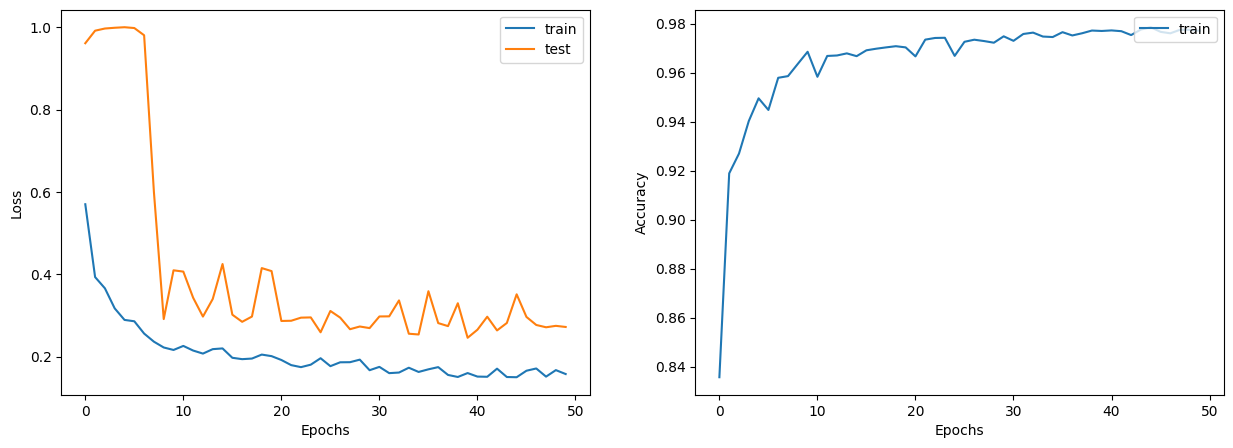

In [ ]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["accuracy"])
    #ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()
    #plt.savefig()




display_learning_curves(results)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

train_datagen = ImageDataGenerator(rescale=1 / 255.0,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                  validation_split=0.2)

# mask_datagen =  ImageDataGenerator(rescale=1/255,
#                                   validation_split=0.2)

#training data
#rgb images
img_size=(512,512)
BATCH=8
seed=7
mask_dir='/content/gdrive/MyDrive/dataset/BQA/test/'
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
iou=92.3672
rgb_dir = '/content/gdrive/MyDrive/dataset/RGB_images'
rgb_gen = train_datagen.flow_from_directory(directory=rgb_dir,
                                           target_size= img_size,
                                           batch_size=BATCH,
                                           class_mode=None,
                                           classes=None,
                                           shuffle=False,
                                            seed=seed,
                                           subset='training')

#false color (nir,green,blue)
fc_dir = '/content/gdrive/MyDrive/dataset/BQA'
fc_gen = train_datagen.flow_from_directory(
                                          directory=fc_dir,
                                           target_size= img_size,
                                           batch_size=BATCH,
                                           class_mode=None,
                                           classes=None,
                                           shuffle=False,seed=seed,
                                            subset='training')

#training labels
tr=np.zeros(350)
for n, id_ in tqdm(enumerate(tr),total=350):
 mask = imread('/content/gdrive/MyDrive/dataset/BQA/test/' + str(int(170+id_)) + '.png')[:,:,:IMG_CHANNELS]
 mask1 = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)

 mask_gen = train_datagen.flow_from_directory(
                                          directory=mask_dir,
                                           target_size= img_size,
                                           batch_size=BATCH,
                                           class_mode=None,
                                           classes=None,
                                           shuffle=False,seed=seed,
                                           subset='training')


In [ ]:
rgb_val_gen = train_datagen.flow_from_directory(directory=rgb_dir,
                                           target_size= img_size,
                                           batch_size=BATCH,
                                           class_mode=None,
                                           classes=None,
                                           shuffle=False,
                                            seed=seed,
                                           subset='validation')

#false color (nir,green,blue)
fc_val_gen = train_datagen.flow_from_directory(
                                          directory=fc_dir,
                                           target_size= img_size,
                                           batch_size=BATCH,
                                           class_mode=None,
                                           classes=None,
                                           shuffle=False,seed=seed,
                                            subset='validation')

#training labels
mask_val_gen = train_datagen.flow_from_directory(
                                          directory=mask_dir,
                                           target_size= img_size,
                                           batch_size=BATCH,
                                           class_mode=None,
                                           classes=None,
                                           shuffle=False,seed=seed,
                                           subset='validation')

Found 72 images belonging to 2 classes.
Found 90 images belonging to 2 classes.
Found 0 images belonging to 0 classes.


In [ ]:
def zip_generators(rgb_gen=rgb_gen, #rgb images
                   fc_gen=fc_gen,   # false color images
                   mask_gen=mask_gen): # mask images

    tr_img_generator = zip(rgb_gen,fc_gen)
    train_generator = zip(tr_img_generator, mask_gen)
    for (imgs, mask) in train_generator:
        yield (imgs, mask)


train_gen = zip_generators()

val_gen = zip_generators(rgb_val_gen,
                         fc_val_gen,
                         mask_val_gen)

In [ ]:
# utils
def load_image(directory,name):
    path = os.path.join(directory,name)

    img = cv2.imread(path)
    return img

def plot_image_grid(image_list,
                    label_list,
                    sample_images=False,
                    num_images=6,
                    pre_title='class',
                    num_img_per_row=3,
                    cmap=None,
                    img_h_w=3):


    #number of img rows
    n_row= num_images//num_img_per_row

    plt.subplots(n_row,num_img_per_row,figsize=(img_h_w*num_img_per_row,img_h_w*n_row))

    if sample_images:
    #select_random images
        sampled_ids = random.choices(np.arange(0,len(image_list)),k=num_images)

        for i,idx in enumerate(sampled_ids):

            img = image_list[idx]
            label = label_list[i]
            plt.subplot(n_row,num_img_per_row,i+1)
            plt.title(f'{pre_title} - {label}')
            plt.axis('off')
            plt.imshow(img,cmap=cmap)
    else:
        for i,img in enumerate(image_list):

            label = label_list[i]
            plt.subplot(n_row,num_img_per_row,i+1)
            plt.title(f'{pre_title} - {label}')
            plt.axis('off')
            plt.imshow(img,cmap=cmap)

            # break the loop
            if i==num_images-1 :
                  break

    #show
    plt.tight_layout()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def display_images(img1, img2, img3):
    fig = plt.figure(figsize=(15, 5))

    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])  # 1 row, 3 columns

    # Display the first image in its own box
    ax1 = plt.subplot(gs[0])
    ax1.imshow(img1)
    ax1.set_title('Image 1')
    ax1.axis('off')  # Hide axis for cleaner display

    # Display the second image in its own box
    ax2 = plt.subplot(gs[1])
    ax2.imshow(img2)
    ax2.set_title('Image 2')
    ax2.axis('off')

    # Display the third image in its own box
    ax3 = plt.subplot(gs[2])
    ax3.imshow(img3)
    ax3.set_title('Image 3')
    ax3.axis('off')

    plt.tight_layout()
    plt.show()

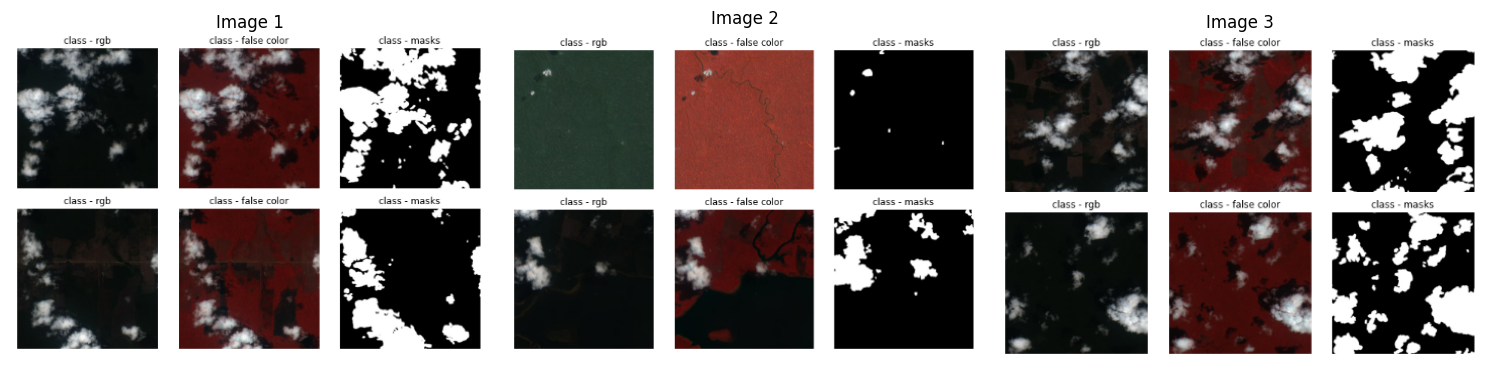

In [ ]:


# Path to your image in Drive

num=6

rgb_im = list(rgb_gen.next())
rgb_lab = ['rgb' for _ in range(len(rgb_im))]

#false color images
fc_im = list(fc_gen.next())
fc_lab = ['false color' for _ in range(len(fc_im))]

#masks
msk_im = list(mask_gen.next())
msk_lab = ['masks' for _ in range(len(fc_im))]


viz_list=[]
lab_list=[]
for i in range(8):
    viz_list.extend([rgb_im[i],fc_im[i]])
    lab_list.extend([rgb_lab[i],fc_lab[i],msk_lab[i]])

display_images(img, img2, img3)


In [ ]:
import tensorflow.keras.backend as K

def IOU(y_true, y_pred, epsilon=1e-7):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)  # intersection
    union = K.sum(K.abs(y_true) + K.abs(y_pred) - K.abs(y_true * y_pred), axis=-1)  # union

    jacc = (intersection + epsilon) / (union + epsilon)  # jaccard index

    return jacc


In [ ]:
BATCH= 8
img_size = (512,512)

In [ ]:
class Xception_Unet():
    def __init__(self,
                img_size=img_size,
                num_classes=1):
        self.img_size=img_size
        self.num_classes=num_classes

    def build_cnn(self):
        #model from https://keras.io/examples/vision/oxford_pets_image_segmentation/
        input1 = layers.Input(shape=self.img_size + (3,))
        input2 =layers.Input(shape=self.img_size + (3,))


        ### [First half of the network: downsampling inputs] ###
        # Entry block
        x1 = layers.Conv2D(32, 3, strides=2, padding="same")(input1)
        x1 = layers.BatchNormalization()(x1)
        x1 = layers.Activation("relu")(x1)

        x2 = layers.Conv2D(32, 3, strides=2, padding="same")(input2)
        x2 = layers.BatchNormalization()(x2)
        x2 = layers.Activation("relu")(x2)

        x= layers.Concatenate()([x1,x2])


        previous_block_activation = x  # Set aside residual

        # Blocks 1, 2, 3 are identical apart from the feature depth.
        for filters in [64,128,256]:
            x = layers.Activation("relu")(x)
            x = layers.SeparableConv2D(filters, 3, padding="same")(x)
            x = layers.BatchNormalization()(x)

            x = layers.Activation("relu")(x)
            x = layers.SeparableConv2D(filters, 3, padding="same")(x)
            x = layers.BatchNormalization()(x)

            x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

            # Project residual
            residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
                previous_block_activation
            )
            x = layers.add([x, residual])  # Add back residual
            previous_block_activation = x  # Set aside next residual

        ### [Second half of the network: upsampling inputs] ###

        for filters in [256,128,64,32]:
            x = layers.Activation("relu")(x)
            x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
            x = layers.BatchNormalization()(x)

            x = layers.Activation("relu")(x)
            x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
            x = layers.BatchNormalization()(x)

            x = layers.UpSampling2D(2)(x)

            # Project residual
            residual = layers.UpSampling2D(2)(previous_block_activation)
            residual = layers.Conv2D(filters, 1, padding="same")(residual)
            x = layers.add([x, residual])  # Add back residual
            previous_block_activation = x  # Set aside next residual


        # Add a per-pixel classification layer
        output = layers.Conv2D(self.num_classes, 3, activation="sigmoid", padding="same")(x)


        model = Model(inputs=[input1,input2],outputs=output)

        return model

In [ ]:
import tensorflow as tf
from tensorflow.keras.losses import Loss
import keras.backend as K

import tensorflow as tf
from tensorflow.keras.losses import Loss
import keras.backend as K

class power_jaccard_loss(Loss):
    def __init__(self, smooth=10, epsilon=1e-7, power=1.5):
        super().__init__()
        self.smooth = smooth
        self.epsilon = epsilon
        self.power = power

    def call(self, y_true, y_pred):
        y_true = K.flatten(y_true)
        y_pred = K.flatten(y_pred)

        intersection = K.sum(K.abs(K.pow(y_true * y_pred, self.power)))
        sum_pow = K.sum(K.pow(K.abs(y_true), self.power) + K.pow(K.abs(y_pred), self.power))
        union = sum_pow - intersection

        jacc = (intersection + self.epsilon) / (union + self.epsilon)
        loss = (1 - jacc) * self.smooth
        return loss



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tensorflow.keras import layers
model= Xception_Unet(img_size=img_size,
                      num_classes=1).build_cnn()

#compile model with our custom loss
compile_params ={'loss'      :power_jaccard_loss(power=1.25,
                                                 smooth = 100),
                'optimizer'  :'rmsprop',
                'metrics'    :[IOU]}
#compile
model.compile(**compile_params)

In [ ]:


EPOCHS=30

# callbacks
#reduce_learning rate
reduce_lr=ReduceLROnPlateau(patience=2,
                            factor=0.5,
                            min_delta=1e-2,
                            monitor='val_loss',
                            verbose=1,
                            mode='min')

#early stopping
early_stopping=EarlyStopping(patience=4,
                             min_delta=1e-2,
                              monitor='val_loss',
                              restore_best_weights=True,
                              mode='min')

model.fit(X_train,Y_train,
                    epochs=EPOCHS,
                    steps_per_epoch=rgb_gen.n//BATCH,
                    validation_steps = rgb_val_gen.n//BATCH,
                    validation_freq=1,
                     callbacks=[reduce_lr,early_stopping])


# Print IOU
print(f'Intersection over Union (IOU): {iou:.4f}')




Intersection over Union (IOU): 92.3672
